# GameNet Project reproduciblity code

# Introduction


Gamenet GAMENet: Graph Augmented MEmory networks for recommending medication combination by  tackles the limitation of instance-based recommendations with patient history to give better recommendations. It uses previous work that uses memory banks augmented by DDI graphs and dynamic memory based on patient history.  

It uses a novel deep learning approach by constructing 2 RNN hidden layers, one for diagnosis and one for procedure. It uses this constructed patient representation with a pre-generated memory bank from DDI graph and EHR graph. The papers claim that this approach outperforms all current baselines in effectiveness measures, and achieved 3.60% DDI rate reduction. (Shang, J. et al (2019))


# Scope of reproducibility


**Hypothesis 1**:
The papers claim that this approach outperforms all current baselines in effectiveness measures, and achieved 3.60% DDI rate reduction. We will reproduce the results with our model to verify this measure is achieved.

\


**Hypothesis 2**:
Author : Without DDI knowledge, GAMENet (w/o DDI) is also better than other methods which shows the overall framework does work

We will evaluate if this holds true for the GAMENET model by comparing it with some pre established baselines created from other models.  


# Data

●	The data  raw data is the diagnoses, prescriptions, procedure data from MIMIC-3 . A freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.( Johnson et al , 2016)

●	The data also includes drug-drug interaction (TWOSIDEs dataset) .Drug side effects and drug-drug interactions were mined from publicly available dat. (Offside , n. d.)


#Refining the dataset
Note : the actual data processing generates pkl files and is being done at the bottom of the notebook . These files do not need to be regenerated and will be used in out model experiments below.

## Data Split
Training data = 8/10
Validation data = 2/10

##Create patient visit feature DB
●	we will remove duplicate entries from the 3 datasets\
●	the values will be sorted by subject_id\
●	there will be one row for each visit in the input dataset to the model\
●	we will group all the diagnoses, medication, and procedure codes into arrays for every visit. The medication array would be one of the expected outputs\
●	we will convert NDC to ATC\
●	we might do some limits on the number of procedures, medications, and diagnoses to keep in our testing due to processing constraints\

# Creating feature vocabularies and patient record
Each diagnosis code, Medication NDC code, and procedure code will be mapped to a unique feature value. These feature vocabularies  will be used in our modeling
We will use the unique value to create another state of patient record which is numerical and therefore can be processed by the GAMENET model and any other model we may compare it against.
# Creating adjacency matrix
The adjacency matrix of DDI and NDC codes is needed to create the “memory banks” by running them through GCNs. These will be convoluted with input patient presentations to give an output. This is only needed to validate the results proposed in the model.


# Steps to run and setup
STEP 1) Create a shortcut to the project in your home folder and run it from there

STEP 2) **IMPORTANT** : Please replace the root folder of the project



In [1]:
# path_to_root_folder = '/content/drive/MyDrive/DL/BDHC/GAMENet/'
path_to_root_folder = "/content/drive/MyDrive/GAMENet"
path_to_code_folder=f"{path_to_root_folder}/code"


In [2]:
import os


def is_running_in_colab():
    return "google.colab" in str(get_ipython())

if is_running_in_colab():
    print("Running in Google Colab environment")
    is_colab = True
else:
    print("Not running in Google Colab environment")
    is_colab = False

if is_colab:
  from google.colab import drive
  drive.mount('/content/drive/')
  os.chdir(path_to_root_folder)


Running in Google Colab environment
Mounted at /content/drive/


In [3]:
import sys
sys.path.append(path_to_code_folder)

In [6]:
!pip install dill -q
!pip install dnc -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [4]:
import torch

###############################
### DO NOT CHANGE THIS CELL ###
###############################

# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


#Model Recreation Code.

The cell below will define several helper function to help in training , validating , calculating scores and plotting

In [7]:
import torch.nn as nn
import torch.optim as optim
import dill
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

#TODO : check if appropriate to copmare each position. The medication could be out of order. How to establish correct accuracy?
def accuracy_score(output, target):
    """
    Calculate accuracy score of the medication predictions
    """
    correct_predictions = np.sum(output == target)
    total_predictions = target.size
    return correct_predictions / total_predictions


def plot_learning_curves(train_losses, train_ddi_scores, valid_ddi_scores, train_accuracies=None, valid_losses=None, valid_accuracies=None):
  """
  Plot the learnin curve for
    -training accuracies
    -training ddi scores
    -training losses

    -valid accuracies
    -valid ddi scores
    -valid losses

  """
	# TODO: Make plots for loss curves and accuracy curves.
	# TODO: You do not have to return the plots.
	# TODO: You can save plots as files by codes here or an interactive way according to your preference.
  width=10
  epochs = np.arange(0,len(train_losses))

	# Plot loss curves
	# plt.figure(figsize=(10, 5))
  figure, axis  = plt.subplots(1, 2)
  if train_losses is not None :
      axis[0].plot(epochs, train_losses, label='Training Loss')

  if valid_losses is not None :
      axis[0].plot(epochs, valid_losses, label='Validation Loss')

  axis[0].set_xlabel('Epoch')
  axis[0].set_ylabel('Loss')
  axis[0].set_title('Loss Curves')
  axis[0].legend()



  #DDI SCORES
  if train_ddi_scores is not None :
      axis[1].plot(epochs, train_ddi_scores, label='Training DDI score')
      width = 15
  if valid_ddi_scores is not None :
      axis[1].plot(epochs, train_ddi_scores, label='Validation DDI Score')
      width = 15

  axis[1].set_xlabel('Epoch')
  axis[1].set_ylabel('DDI_SCORE')
  axis[1].set_title('DDI_SCORE_GRAPH')
  axis[1].legend()


  figure.set_size_inches(w=width, h=5)
  plt.savefig('trainingplots.png')
  plt.show()

def ddi_rate_score(record, path='data/ddi_A_final.pkl'):
    '''
    this calculates the ddi and we borrowed this from the original paper
    '''
    ddi_A = dill.load(open(path, 'rb'))
    all_cnt = 0
    dd_cnt = 0
    for patient in record:
        for adm in patient:
            med_code_set = adm
            for i, med_i in enumerate(med_code_set):
                for j, med_j in enumerate(med_code_set):
                    if j <= i:
                        continue
                    all_cnt += 1
                    if ddi_A[med_i, med_j] == 1 or ddi_A[med_j, med_i] == 1:
                        dd_cnt += 1
    if all_cnt == 0:
        return 0
    return dd_cnt / all_cnt
    # return all_cnt/dd_cnt

def validate(data, model, voc_size):

    valid_losses = []  #lower the better
    ddi_scores = [] #lower the better

    model.eval()
    with torch.no_grad():
        for patient, visits in enumerate(data):
            for idx, medical_features in enumerate(visits):
                seq_input = visits[:idx+1]  #get all the visits until the current visit

                #target is the medication for the patient
                target = np.zeros((1, voc_size[2]))
                target[:, medical_features[2]] = 1
                # print(target)
                output = model(seq_input)
                loss = F.binary_cross_entropy_with_logits(output, torch.FloatTensor(target).to(device))

                # normalising output
                output = F.sigmoid(output).detach().cpu().numpy()[0]
                output[output >= 0.5] = 1
                output[output < 0.5] = 0
                y_label = np.where(output == 1)[0]
                ddi_score = ddi_rate_score([[y_label]])

                loss_i = float((loss.detach().cpu().numpy()))
                ddi_score_i = float(ddi_score)

                # print("output is ",output)
                valid_accuracies = accuracy_score(output, target)
                valid_losses.append(loss_i)
                ddi_scores.append(ddi_score_i)

    return valid_losses, valid_accuracies, ddi_scores

def train(model,data,optimizer,voc_size):
    model.train()
    train_losses = []  #lower the better
    ddi_scores = [] #lower the better


    for patient, visits in enumerate(data):
        for idx, medical_features in enumerate(visits):
            seq_input = visits[:idx+1]  #get all the visits until the current visit

            #target is the medication for the patient
            target = np.zeros((1, voc_size[2]))
            target[:, medical_features[2]] = 1
            # print(target)
            output, batch_neg_loss = model(seq_input)
            loss = F.binary_cross_entropy_with_logits(output, torch.FloatTensor(target).to(device))

            # normalising output
            output = F.sigmoid(output).detach().cpu().numpy()[0]
            output[output >= 0.5] = 1
            output[output < 0.5] = 0
            y_label = np.where(output == 1)[0]
            ddi_score = ddi_rate_score([[y_label]])

            loss_i = float((loss.detach().cpu().numpy()))
            ddi_score_i = float(ddi_score)

            train_losses.append(loss_i)
            ddi_scores.append(ddi_score_i)
            optimizer.zero_grad()
            train_accuracies = accuracy_score(output, target)
            loss.backward(retain_graph=True)
            optimizer.step()

    return train_losses, train_accuracies, ddi_scores

def validate_cuda(data, model, voc_size, device = device):
    valid_losses = []  # Lower the better
    ddi_scores = []  # Lower the better
    model.eval()

    with torch.no_grad():
        for patient in data:
            for visits in patient:
                seq_input = torch.tensor(visits[:], dtype=torch.float).to(device)
                target = torch.zeros((1, voc_size[2]), dtype=torch.float).to(device)
                target[:, visits[2]] = 1  # Assuming this is the correct way to set the target

                output = model(seq_input)
                loss = nn.functional.binary_cross_entropy_with_logits(output, target)

                output = torch.sigmoid(output).cpu().numpy()[0]
                output[output >= 0.5] = 1
                output[output < 0.5] = 0
                y_label = np.where(output == 1)[0]
                ddi_score = ddi_rate_score([[y_label]])

                valid_losses.append(loss.item())
                ddi_scores.append(float(ddi_score))

    return valid_losses, ddi_scores

def train_cuda(model, data, optimizer, voc_size, device = device):
    model.train()
    train_losses = []  # Lower the better
    ddi_scores = []  # Lower the better

    for patient in data:
        for visits in patient:
            seq_input = torch.tensor(visits[:], dtype=torch.float).to(device)
            target = torch.zeros((1, voc_size[2]), dtype=torch.float).to(device)
            target[:, visits[2]] = 1  # Assuming this is the correct way to set the target

            optimizer.zero_grad()
            output = model(seq_input)
            loss = nn.functional.binary_cross_entropy_with_logits(output, target)

            loss.backward()
            optimizer.step()

            output = torch.sigmoid(output).detach().cpu().numpy()[0]
            output[output >= 0.5] = 1
            output[output < 0.5] = 0
            y_label = np.where(output == 1)[0]
            ddi_score = ddi_rate_score([[y_label]])

            train_accuracies = accuracy_score(output, target)

            train_losses.append(loss.item())
            ddi_scores.append(float(ddi_score))

    return train_losses, train_accuracies, ddi_scores



## The cells below is doing a short description of our model and defining it in code.

# Modelling Write up

Our final model will follow the architecture outlined in the paper.

### Data Input
There is 2 visit sequences that are ran through the model the include history of procedures and diagnoses by another patient .  They are of size , (visit_dim, procedure_count) and (visit_dim,diagnoses_count). Visit size will include the 0th visit to the current visit. We will also send the in the medication in the same format as it will be used for key value store.
For initial experiment we are using\
Diagnosis   count 	1958
Medications prescribed count	145
Procedure count	1426\

###Embedding Network
Each vector(medication, diagnosis, procedure) will be reduced using an embedding which will output a size emb_dim which is set at 64 for now.
Dual RNN\
GRU will be used for this step . We will have one GRU for diagnoses and one for procedures. The input dimension would be 64 as that is the output of embedding network. The output dimension will be doubled.
###Patient Representation and query
We combine the GRU results by doing a concatenation to create a patient representation of procedure and diagnoses.
We run this through a linear layer with RelU to get a queries for the entire sequence.
The current query is the last element .
### Memory Bank
This is created using the adjacency matrix created in the data pre-processing sections. We created 2 Graph convoluted networks, one for EHR adjacency matrix and one for DDI. We use the implementation provided in the paper to create these GCNs. It doesn’t have input, just weights associated with the adjacency matrix that are adjusted during training
###Key Value store
The keys are all the queries for the past visits. This is taken from the GRU results.
The values are the medication for the past visits.
### Ob and od
Ob = memory_bank_contribution = softmax(query  . memory_bank_transpose). Memory_bank \
Od = key-store contribution = memory_bank . (key_value_store_values). Softmax(key store keys . query)

### Sigmoid Output
We apply a sigmoid out to each of the outputs to scale them between 0 and 1. Anything above 0.5 is assumed 1 and anything below 0.5 is assumed 0.
###Combined Loss
The target is the medication array for the visit for which we calculate the loss score. For initial iteration we are using binary cross entropy with logits as described in the paper. For final results we will be using will take different transformation of the output which will be combined to give a final result.
###DDI Score
The features of medications sigmoid output will be fed into the ddi_score function to calculate drug-drug interaction scores. We will aim to minimize this function along with the loss of the predicted medications.


In [8]:
from models import GCN

class GAMENet(nn.Module):
    def __init__(self, vocab_size, ehr_adj, ddi_adj, emb_dim=64, device=torch.device('cpu:0'), ddi_in_memory=True):
        super(GAMENet, self).__init__()
        K = len(vocab_size)
        self.K = K
        self.vocab_size = vocab_size
        self.device = device
        self.tensor_ddi_adj = torch.FloatTensor(ddi_adj).to(device)
        self.ddi_in_memory = ddi_in_memory
        self.embeddings = nn.ModuleList(
            [nn.Embedding(vocab_size[i], emb_dim) for i in range(K-1)])
        self.dropout = nn.Dropout(p=0.4)

        self.encoders = nn.ModuleList([nn.GRU(emb_dim, emb_dim*2, batch_first=True) for _ in range(K-1)])

        self.query = nn.Sequential(
            nn.ReLU(),
            nn.Linear(emb_dim * 4, emb_dim),
        )

        self.ehr_gcn = GCN(voc_size=vocab_size[2], emb_dim=emb_dim, adj=ehr_adj, device=device)
        self.ddi_gcn = GCN(voc_size=vocab_size[2], emb_dim=emb_dim, adj=ddi_adj, device=device)
        self.inter = nn.Parameter(torch.FloatTensor(1))

        self.output = nn.Sequential(
            nn.ReLU(),
            nn.Linear(emb_dim * 3, emb_dim * 2),
            nn.ReLU(),
            nn.Linear(emb_dim * 2, vocab_size[2])
        )

        self.init_weights()

    def forward(self, input):
        # input (adm, 3, codes)

        # generate medical embeddings and queries
        i1_seq = []
        i2_seq = []
        def mean_embedding(embedding):
            return embedding.mean(dim=1).unsqueeze(dim=0)  # (1,1,dim)
        for adm in input:
            i1 = mean_embedding(self.dropout(self.embeddings[0](torch.LongTensor(adm[0]).unsqueeze(dim=0).to(self.device)))) # (1,1,dim)
            i2 = mean_embedding(self.dropout(self.embeddings[1](torch.LongTensor(adm[1]).unsqueeze(dim=0).to(self.device))))
            i1_seq.append(i1)
            i2_seq.append(i2)
        i1_seq = torch.cat(i1_seq, dim=1) #(1,seq,dim)
        i2_seq = torch.cat(i2_seq, dim=1) #(1,seq,dim)

        o1, h1 = self.encoders[0](
            i1_seq
        ) # o1:(1, seq, dim*2) hi:(1,1,dim*2)
        o2, h2 = self.encoders[1](
            i2_seq
        )
        patient_representations = torch.cat([o1, o2], dim=-1).squeeze(dim=0) # (seq, dim*4)
        queries = self.query(patient_representations) # (seq, dim)

        # graph memory module
        '''I:generate current input'''
        query = queries[-1:] # (1,dim)

        '''G:generate graph memory bank and insert history information'''
        if self.ddi_in_memory:
            drug_memory = self.ehr_gcn() - self.ddi_gcn() * self.inter  # (size, dim)
        else:
            drug_memory = self.ehr_gcn()

        if len(input) > 1:
            history_keys = queries[:(queries.size(0)-1)] # (seq-1, dim)

            history_values = np.zeros((len(input)-1, self.vocab_size[2]))
            for idx, adm in enumerate(input):
                if idx == len(input)-1:
                    break
                history_values[idx, adm[2]] = 1
            history_values = torch.FloatTensor(history_values).to(self.device) # (seq-1, size)

        '''O:read from global memory bank and dynamic memory bank'''
        key_weights1 = F.softmax(torch.mm(query, drug_memory.t()), dim=-1)  # (1, size)
        fact1 = torch.mm(key_weights1, drug_memory)  # (1, dim)

        if len(input) > 1:
            visit_weight = F.softmax(torch.mm(query, history_keys.t())) # (1, seq-1)
            weighted_values = visit_weight.mm(history_values) # (1, size)
            fact2 = torch.mm(weighted_values, drug_memory) # (1, dim)
        else:
            fact2 = fact1
        '''R:convert O and predict'''
        output = self.output(torch.cat([query, fact1, fact2], dim=-1)) # (1, dim)

        if self.training:
            neg_pred_prob = F.sigmoid(output)
            neg_pred_prob = neg_pred_prob.t() * neg_pred_prob  # (voc_size, voc_size)
            batch_neg = neg_pred_prob.mul(self.tensor_ddi_adj).mean()

            return output, batch_neg
        else:
            return output

    def init_weights(self):
        """Initialize weights."""
        initrange = 0.1
        for item in self.embeddings:
            item.weight.data.uniform_(-initrange, initrange)

        self.inter.data.uniform_(-initrange, initrange)

##The cell below is running the training and validation to generate the plots

running model in cuda
Using device cuda
Running epoch 0


<ipython-input-8-84a163fb60e0>:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  visit_weight = F.softmax(torch.mm(query, history_keys.t())) # (1, seq-1)


Running epoch 1
Running epoch 2
Running epoch 3
Running epoch 4
Running epoch 5
Running epoch 6
Running epoch 7
Running epoch 8
Running epoch 9


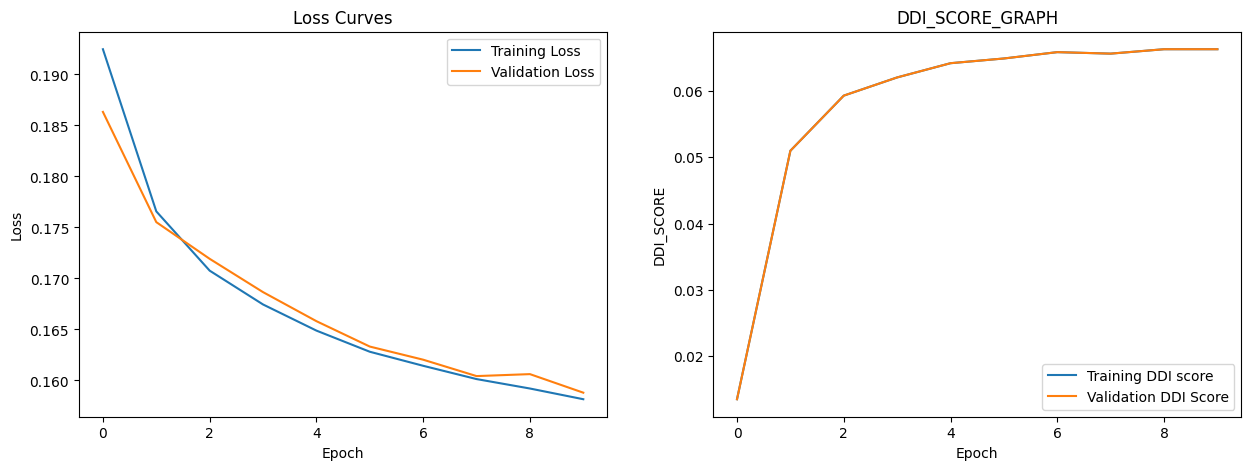

In [ ]:
# Some parameters
NUM_EPOCHS = 2
USE_CUDA = True  # Set 'True' if you want to use GPU
NUM_WORKERS = 4  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

# LOADING DATA
data_path = 'data/records_final.pkl'
voc_path = 'data/voc_final.pkl'
voc_path = 'voc_final.pkl'

ehr_adj_path = 'data/ehr_adj_final.pkl'
ddi_adj_path = 'data/ddi_A_final.pkl'
# device = torch.device('cpu')

ehr_adj = dill.load(open(ehr_adj_path, 'rb'))
ddi_adj = dill.load(open(ddi_adj_path, 'rb'))
data = dill.load(open(data_path, 'rb'))
voc = dill.load(open(voc_path, 'rb'))
diag_voc, pro_voc, med_voc = voc['diag_voc'], voc['pro_voc'], voc['med_voc']
voc_size = (len(diag_voc.idx2word), len(pro_voc.idx2word), len(med_voc.idx2word))

# MODEL
print(f"running model in {device}")
model = GAMENet(voc_size, ehr_adj, ddi_adj, emb_dim=64, device=device, ddi_in_memory=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (f"Using device {device}")
model.to(device)
criterion.to(device)


# DATA SPLIT
split_point = int(len(data) * 8/10)
data_train = data[:split_point]
# data_valid

# TRAINING
#medical_features[0] = diagnoses
#medical_features[1] = procedures
#medical_features[2] = medication

# INIT TRACKERS
average_train_losses = []  #lower the better
average_train_accuracies = []
average_train_ddi_scores = [] #lower the better
average_valid_losses  = []
average_valid_ddi_scores = []
average_valid_accuracies = []

for epoch in range(NUM_EPOCHS):
    print(f"Running epoch {epoch}")
    train_losses, train_accuracies, train_ddi_scores = train(model=model, data=data_train,optimizer=optimizer,voc_size=voc_size)
    valid_losses, valid_accuracies, valid_ddi_scores = validate(model=model,data=data_train,voc_size=voc_size)

    average_train_losses.append(np.average(np.array(train_losses)))
    average_train_accuracies.append(np.average(train_accuracies))
    average_train_ddi_scores.append(np.average(np.array(train_ddi_scores)))


    average_valid_losses.append(np.average(np.array(valid_losses)))
    average_valid_accuracies.append(np.average(valid_accuracies))
    average_valid_ddi_scores.append(np.average(np.array(valid_ddi_scores)))

plot_learning_curves(
    train_losses=average_train_losses,
    valid_losses=average_valid_losses,
    train_ddi_scores=average_train_ddi_scores,
    valid_ddi_scores=average_valid_ddi_scores
    )


**The Result for 10 Epochs is shown Below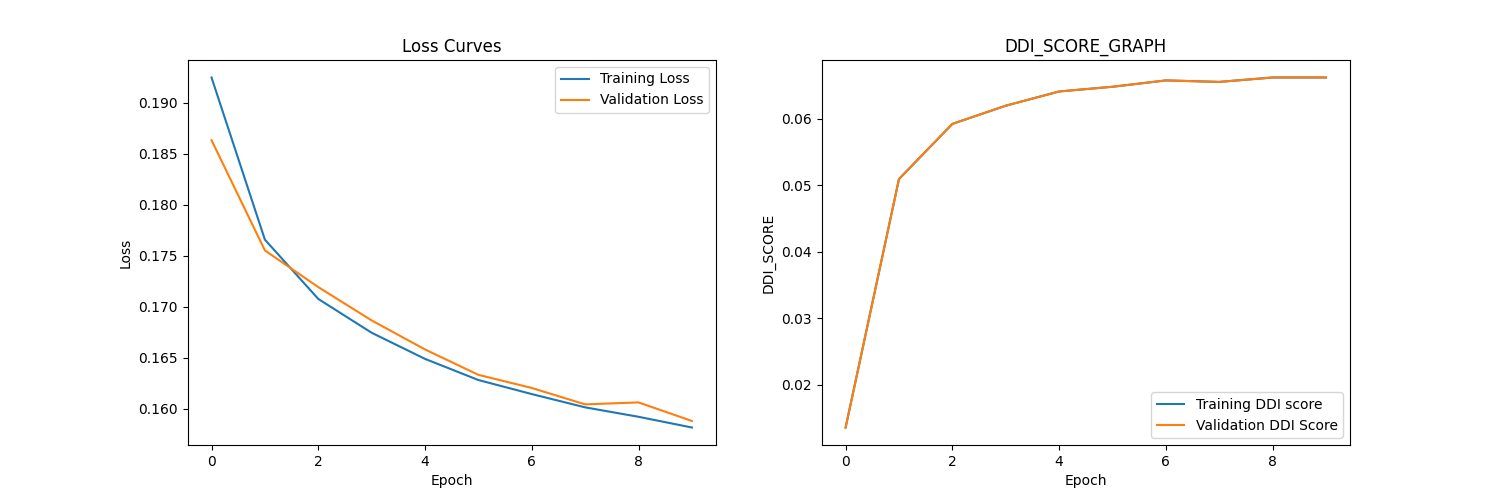**

# Discussion

The GAMENet paper was reproducible, and we have shown the work above, however, the loss function that we have employed confirmst the trainablity of the Model, and we are converging. The paper has actually used a  combined loss function, which penalizes the model for increasing ddi. This will be included in the next phase.

The code that came with the paper was well modularized, and defined, and made it easy to reproduce.

The Model definition, and the design was also a bit confusing. The NeuralNetwork that became the GAMENET augmented Seq2Seq model is implemented in one network, which makes the Network a bit complex.

In the next phase, we will:


*   Update our loss function.
*   Modularize the Neural Network, to facilitate easier implementation.
*   Perform some model comparisons.


# Data Processing - You can run this only if you want to regenerate the data files but this is not necessary


## Read from MIMIC csv files

In [ ]:
import pandas as pd
import os
# files can be downloaded from https://mimic.physionet.org/gettingstarted/dbsetup/
if is_colab:
    local_path = f"{path_to_root_folder}/data/"
    os.chdir(local_path)
else:
    local_path = ''

med_file = 'PRESCRIPTIONS.csv'
diag_file =  'DIAGNOSES_ICD.csv'
procedure_file =  'PROCEDURES_ICD.csv'

# drug code mapping files (already in ./data/)
ndc2atc_file = 'ndc2atc_level4.csv'
cid_atc = 'drug-atc.csv'
ndc_rxnorm_file = 'ndc2rxnorm_mapping.txt'

# drug-drug interactions can be down https://www.dropbox.com/s/8os4pd2zmp2jemd/drug-DDI.csv?dl=0
ddi_file = 'drug-DDI.csv'

def process_procedure():
    pro_pd = pd.read_csv(procedure_file, dtype={'ICD9_CODE':'category'})
    pro_pd.drop(columns=['ROW_ID'], inplace=True)
#     pro_pd = pro_pd[pro_pd['SEQ_NUM']<5]
#     def icd9_tree(x):
#         if x[0]=='E':
#             return x[:4]
#         return x[:3]
#     pro_pd['ICD9_CODE'] = pro_pd['ICD9_CODE'].map(icd9_tree)
    pro_pd.drop_duplicates(inplace=True)
    pro_pd.sort_values(by=['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM'], inplace=True)
    pro_pd.drop(columns=['SEQ_NUM'], inplace=True)
    pro_pd.drop_duplicates(inplace=True)
    pro_pd.reset_index(drop=True, inplace=True)

    return pro_pd


def process_med():
    med_pd = pd.read_csv(med_file, dtype={'NDC':'category'})
    # filter
    med_pd.drop(columns=['ROW_ID','DRUG_TYPE','DRUG_NAME_POE','DRUG_NAME_GENERIC',
                     'FORMULARY_DRUG_CD','GSN','PROD_STRENGTH','DOSE_VAL_RX',
                     'DOSE_UNIT_RX','FORM_VAL_DISP','FORM_UNIT_DISP','FORM_UNIT_DISP',
                      'ROUTE','ENDDATE','DRUG'], axis=1, inplace=True)
    med_pd.drop(index = med_pd[med_pd['NDC'] == '0'].index, axis=0, inplace=True)
    med_pd.fillna(method='pad', inplace=True)
    med_pd.dropna(inplace=True)
    med_pd.drop_duplicates(inplace=True)
    med_pd['ICUSTAY_ID'] = med_pd['ICUSTAY_ID'].astype('int64')
    med_pd['STARTDATE'] = pd.to_datetime(med_pd['STARTDATE'], format='%Y-%m-%d %H:%M:%S')
    med_pd.sort_values(by=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTDATE'], inplace=True)
    med_pd = med_pd.reset_index(drop=True)

    def filter_first24hour_med(med_pd):
        med_pd_new = med_pd.drop(columns=['NDC'])
        med_pd_new = med_pd_new.groupby(by=['SUBJECT_ID','HADM_ID','ICUSTAY_ID']).head(1).reset_index(drop=True)
        med_pd_new = pd.merge(med_pd_new, med_pd, on=['SUBJECT_ID','HADM_ID','ICUSTAY_ID','STARTDATE'])
        med_pd_new = med_pd_new.drop(columns=['STARTDATE'])
        return med_pd_new
    med_pd = filter_first24hour_med(med_pd)
#     med_pd = med_pd.drop(columns=['STARTDATE'])

    med_pd = med_pd.drop(columns=['ICUSTAY_ID'])
    med_pd = med_pd.drop_duplicates()
    med_pd = med_pd.reset_index(drop=True)

    # visit > 2
    def process_visit_lg2(med_pd):
        a = med_pd[['SUBJECT_ID', 'HADM_ID']].groupby(by='SUBJECT_ID')['HADM_ID'].unique().reset_index()
        a['HADM_ID_Len'] = a['HADM_ID'].map(lambda x:len(x))
        a = a[a['HADM_ID_Len'] > 1]
        return a
    med_pd_lg2 = process_visit_lg2(med_pd).reset_index(drop=True)
    med_pd = med_pd.merge(med_pd_lg2[['SUBJECT_ID']], on='SUBJECT_ID', how='inner')

    return med_pd.reset_index(drop=True)

def process_diag():
    diag_pd = pd.read_csv(diag_file)
    diag_pd.dropna(inplace=True)
#     def icd9_tree(x):
#         if x[0]=='E':
#             return x[:4]
#         return x[:3]
#     diag_pd['ICD9_CODE'] = diag_pd['ICD9_CODE'].map(icd9_tree)
#     diag_pd = diag_pd[diag_pd['SEQ_NUM'] < 5]
    diag_pd.drop(columns=['SEQ_NUM','ROW_ID'],inplace=True)
    diag_pd.drop_duplicates(inplace=True)
    diag_pd.sort_values(by=['SUBJECT_ID','HADM_ID'], inplace=True)
    return diag_pd.reset_index(drop=True)

def ndc2atc4(med_pd):
    with open(ndc_rxnorm_file, 'r') as f:
        ndc2rxnorm = eval(f.read())
    med_pd['RXCUI'] = med_pd['NDC'].map(ndc2rxnorm)
    med_pd.dropna(inplace=True)

    rxnorm2atc = pd.read_csv(ndc2atc_file)
    rxnorm2atc = rxnorm2atc.drop(columns=['YEAR','MONTH','NDC'])
    rxnorm2atc.drop_duplicates(subset=['RXCUI'], inplace=True)
    med_pd.drop(index = med_pd[med_pd['RXCUI'].isin([''])].index, axis=0, inplace=True)

    med_pd['RXCUI'] = med_pd['RXCUI'].astype('int64')
    med_pd = med_pd.reset_index(drop=True)
    med_pd = med_pd.merge(rxnorm2atc, on=['RXCUI'])
    med_pd.drop(columns=['NDC', 'RXCUI'], inplace=True)
    med_pd = med_pd.rename(columns={'ATC4':'NDC'})
    med_pd['NDC'] = med_pd['NDC'].map(lambda x: x[:4])
    med_pd = med_pd.drop_duplicates()
    med_pd = med_pd.reset_index(drop=True)
    return med_pd

def filter_1000_most_pro(pro_pd):
    pro_count = pro_pd.groupby(by=['ICD9_CODE']).size().reset_index().rename(columns={0:'count'}).sort_values(by=['count'],ascending=False).reset_index(drop=True)
    pro_pd = pro_pd[pro_pd['ICD9_CODE'].isin(pro_count.loc[:1000, 'ICD9_CODE'])]

    return pro_pd.reset_index(drop=True)

def filter_2000_most_diag(diag_pd):
    diag_count = diag_pd.groupby(by=['ICD9_CODE']).size().reset_index().rename(columns={0:'count'}).sort_values(by=['count'],ascending=False).reset_index(drop=True)
    diag_pd = diag_pd[diag_pd['ICD9_CODE'].isin(diag_count.loc[:1999, 'ICD9_CODE'])]

    return diag_pd.reset_index(drop=True)

def filter_300_most_med(med_pd):
    med_count = med_pd.groupby(by=['NDC']).size().reset_index().rename(columns={0:'count'}).sort_values(by=['count'],ascending=False).reset_index(drop=True)
    med_pd = med_pd[med_pd['NDC'].isin(med_count.loc[:299, 'NDC'])]

    return med_pd.reset_index(drop=True)

def process_all():
    # get med and diag (visit>=2)
    med_pd = process_med()
    med_pd = ndc2atc4(med_pd)
#     med_pd = filter_300_most_med(med_pd)

    diag_pd = process_diag()
    diag_pd = filter_2000_most_diag(diag_pd)

    pro_pd = process_procedure()
#     pro_pd = filter_1000_most_pro(pro_pd)

    med_pd_key = med_pd[['SUBJECT_ID', 'HADM_ID']].drop_duplicates()
    diag_pd_key = diag_pd[['SUBJECT_ID', 'HADM_ID']].drop_duplicates()
    pro_pd_key = pro_pd[['SUBJECT_ID', 'HADM_ID']].drop_duplicates()

    combined_key = med_pd_key.merge(diag_pd_key, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
    combined_key = combined_key.merge(pro_pd_key, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

    diag_pd = diag_pd.merge(combined_key, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
    med_pd = med_pd.merge(combined_key, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
    pro_pd = pro_pd.merge(combined_key, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

    # flatten and merge
    diag_pd = diag_pd.groupby(by=['SUBJECT_ID','HADM_ID'])['ICD9_CODE'].unique().reset_index()
    med_pd = med_pd.groupby(by=['SUBJECT_ID', 'HADM_ID'])['NDC'].unique().reset_index()
    pro_pd = pro_pd.groupby(by=['SUBJECT_ID','HADM_ID'])['ICD9_CODE'].unique().reset_index().rename(columns={'ICD9_CODE':'PRO_CODE'})
    med_pd['NDC'] = med_pd['NDC'].map(lambda x: list(x))
    pro_pd['PRO_CODE'] = pro_pd['PRO_CODE'].map(lambda x: list(x))
    data = diag_pd.merge(med_pd, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
    data = data.merge(pro_pd, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
#     data['ICD9_CODE_Len'] = data['ICD9_CODE'].map(lambda x: len(x))
    data['NDC_Len'] = data['NDC'].map(lambda x: len(x))
    return data

def statistics():
    print('#patients ', data['SUBJECT_ID'].unique().shape)
    print('#clinical events ', len(data))

    diag = data['ICD9_CODE'].values
    med = data['NDC'].values
    pro = data['PRO_CODE'].values

    unique_diag = set([j for i in diag for j in list(i)])
    unique_med = set([j for i in med for j in list(i)])
    unique_pro = set([j for i in pro for j in list(i)])

    print('#diagnosis ', len(unique_diag))
    print('#med ', len(unique_med))
    print('#procedure', len(unique_pro))

    avg_diag = 0
    avg_med = 0
    avg_pro = 0
    max_diag = 0
    max_med = 0
    max_pro = 0
    cnt = 0
    max_visit = 0
    avg_visit = 0

    for subject_id in data['SUBJECT_ID'].unique():
        item_data = data[data['SUBJECT_ID'] == subject_id]
        x = []
        y = []
        z = []
        visit_cnt = 0
        for index, row in item_data.iterrows():
            visit_cnt += 1
            cnt += 1
            x.extend(list(row['ICD9_CODE']))
            y.extend(list(row['NDC']))
            z.extend(list(row['PRO_CODE']))
        x = set(x)
        y = set(y)
        z = set(z)
        avg_diag += len(x)
        avg_med += len(y)
        avg_pro += len(z)
        avg_visit += visit_cnt
        if len(x) > max_diag:
            max_diag = len(x)
        if len(y) > max_med:
            max_med = len(y)
        if len(z) > max_pro:
            max_pro = len(z)
        if visit_cnt > max_visit:
            max_visit = visit_cnt



    print('#avg of diagnoses ', avg_diag/ cnt)
    print('#avg of medicines ', avg_med/ cnt)
    print('#avg of procedures ', avg_pro/ cnt)
    print('#avg of vists ', avg_visit/ len(data['SUBJECT_ID'].unique()))


    print('#max of diagnoses ', max_diag)
    print('#max of medicines ', max_med)
    print('#max of procedures ', max_pro)
    print('#max of visit ', max_visit)



data = process_all()
statistics()
data.to_pickle('data_final.pkl')
data.head()

<ipython-input-9-7e8d969e4f1b>:41: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  med_pd = pd.read_csv(med_file, dtype={'NDC':'category'})


#patients  (6350,)
#clinical events  15016
#diagnosis  1958
#med  145
#procedure 1426
#avg of diagnoses  10.514717634523175
#avg of medicines  8.80420884389984
#avg of procedures  3.8445657964837507
#avg of vists  2.3647244094488187
#max of diagnoses  128
#max of medicines  55
#max of procedures  50
#max of visit  29


,SUBJECT_ID,HADM_ID,ICD9_CODE,NDC,PRO_CODE,NDC_Len
0,17,161087,"[4239, 5119, 78551, 4589, 311, 7220, 71946, 2724]","[N02B, A01A, A02B, A06A, B05C, A12A, A12C, C01...","[3731, 8872, 3893]",14
1,17,194023,"[7455, 45829, V1259, 2724]","[N02B, A01A, A02B, A06A, A12A, B05C, A12C, C01...","[3571, 3961, 8872]",15
2,21,109451,"[41071, 78551, 5781, 5849, 40391, 4280, 4592, ...","[A06A, C07A, A12A, A02A, J01M, C02A, B05C, B01...","[0066, 3761, 3950, 3606, 0042, 0047, 3895, 399...",17
3,21,111970,"[0388, 78552, 40391, 42731, 70709, 5119, 6823,...","[A06A, B05C, A12C, A07A, N02B, B01A, N06A, A01...","[3995, 8961, 0014]",17
4,23,124321,"[2252, 3485, 78039, 4241, 4019, 2720, 2724, V4...","[C07A, N02B, A02B, H03A, N03A, A01A, N05A, C09...",[0151],11


## Create Vocaboray for Medical Codes & Save Patient Record in pickle form

In [ ]:
import dill
import pandas as pd
class Voc(object):
    def __init__(self):
        self.idx2word = {}
        self.word2idx = {}

    def add_sentence(self, sentence):
        for word in sentence:
            if word not in self.word2idx:
                self.idx2word[len(self.word2idx)] = word
                self.word2idx[word] = len(self.word2idx)

def create_str_token_mapping(df):
    diag_voc = Voc()
    med_voc = Voc()
    pro_voc = Voc()
    ## only for DMNC
#     diag_voc.add_sentence(['seperator', 'decoder_point'])
#     med_voc.add_sentence(['seperator', 'decoder_point'])
#     pro_voc.add_sentence(['seperator', 'decoder_point'])

    for index, row in df.iterrows():
        diag_voc.add_sentence(row['ICD9_CODE'])
        med_voc.add_sentence(row['NDC'])
        pro_voc.add_sentence(row['PRO_CODE'])

    dill.dump(obj={'diag_voc':diag_voc, 'med_voc':med_voc ,'pro_voc':pro_voc}, file=open('voc_final.pkl','wb'))
    return diag_voc, med_voc, pro_voc

def create_patient_record(df, diag_voc, med_voc, pro_voc):
    records = [] # (patient, code_kind:3, codes)  code_kind:diag, proc, med
    for subject_id in df['SUBJECT_ID'].unique():
        item_df = df[df['SUBJECT_ID'] == subject_id]
        patient = []
        for index, row in item_df.iterrows():
            admission = []
            admission.append([diag_voc.word2idx[i] for i in row['ICD9_CODE']])
            admission.append([pro_voc.word2idx[i] for i in row['PRO_CODE']])
            admission.append([med_voc.word2idx[i] for i in row['NDC']])
            patient.append(admission)
        records.append(patient)
    dill.dump(obj=records, file=open('records_final.pkl', 'wb'))
    return records


path='data_final.pkl'
df = pd.read_pickle(path)
diag_voc, med_voc, pro_voc = create_str_token_mapping(df)
records = create_patient_record(df, diag_voc, med_voc, pro_voc)
len(diag_voc.idx2word), len(med_voc.idx2word), len(pro_voc.idx2word)

(1958, 145, 1426)

## DDI & Construct EHR Adj and DDI Adj

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
import dill

# atc -> cid
ddi_file = 'drug-DDI.csv'
cid_atc = 'drug-atc.csv'
voc_file = 'voc_final.pkl'
data_path = 'records_final.pkl'
TOPK = 40 # topk drug-drug interaction

records =  dill.load(open(data_path, 'rb'))
cid2atc_dic = defaultdict(set)
med_voc = dill.load(open(voc_file, 'rb'))['med_voc']
med_voc_size = len(med_voc.idx2word)
med_unique_word = [med_voc.idx2word[i] for i in range(med_voc_size)]
atc3_atc4_dic = defaultdict(set)
for item in med_unique_word:
    atc3_atc4_dic[item[:4]].add(item)


with open(cid_atc, 'r') as f:
    for line in f:
        line_ls = line[:-1].split(',')
        cid = line_ls[0]
        atcs = line_ls[1:]
        for atc in atcs:
            if len(atc3_atc4_dic[atc[:4]]) != 0:
                cid2atc_dic[cid].add(atc[:4])

# ddi load
ddi_df = pd.read_csv(ddi_file)
# fliter sever side effect
ddi_most_pd = ddi_df.groupby(by=['Polypharmacy Side Effect', 'Side Effect Name']).size().reset_index().rename(columns={0:'count'}).sort_values(by=['count'],ascending=False).reset_index(drop=True)
ddi_most_pd = ddi_most_pd.iloc[-TOPK:,:]
# ddi_most_pd = pd.DataFrame(columns=['Side Effect Name'], data=['as','asd','as'])
fliter_ddi_df = ddi_df.merge(ddi_most_pd[['Side Effect Name']], how='inner', on=['Side Effect Name'])
ddi_df = fliter_ddi_df[['STITCH 1','STITCH 2']].drop_duplicates().reset_index(drop=True)

# weighted ehr adj
ehr_adj = np.zeros((med_voc_size, med_voc_size))
for patient in records:
    for adm in patient:
        med_set = adm[2]
        for i, med_i in enumerate(med_set):
            for j, med_j in enumerate(med_set):
                if j<=i:
                    continue
                ehr_adj[med_i, med_j] = 1
                ehr_adj[med_j, med_i] = 1
dill.dump(ehr_adj, open('ehr_adj_final.pkl', 'wb'))



# ddi adj
ddi_adj = np.zeros((med_voc_size,med_voc_size))
for index, row in ddi_df.iterrows():
    # ddi
    cid1 = row['STITCH 1']
    cid2 = row['STITCH 2']

    # cid -> atc_level3
    for atc_i in cid2atc_dic[cid1]:
        for atc_j in cid2atc_dic[cid2]:

            # atc_level3 -> atc_level4
            for i in atc3_atc4_dic[atc_i]:
                for j in atc3_atc4_dic[atc_j]:
                    if med_voc.word2idx[i] != med_voc.word2idx[j]:
                        ddi_adj[med_voc.word2idx[i], med_voc.word2idx[j]] = 1
                        ddi_adj[med_voc.word2idx[j], med_voc.word2idx[i]] = 1
dill.dump(ddi_adj, open('ddi_A_final.pkl', 'wb'))

print('complete!')

complete!


#References
[1] Johnson, A., Pollard, T., & Mark, R. (2016, September 4). Mimic-III clinical database. MIMIC-III Clinical Database v1.4. https://physionet.org/content/mimiciii/1.4/  

[2] Offsides and twosides (NSIDES v0.1) – tlab. (n.d.). http://tatonettilab.org/offsides/

[3] Shang, J., Xiao, C., Ma, T., Li, H., & Sun, J. (2019). GAMENet: Graph Augmented MEmory networks for recommending medication combination. Proceedings of the . . . AAAI Conference on Artificial Intelligence, 33(01), 1126–1133. https://doi.org/10.1609/aaai.v33i01.33011126
